In [3]:
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions.categorical import Categorical
from collections import deque
import numpy as np

In [4]:
# Create a maze
# All four boundaries are walls (maze[i][j] = 1 if blocked)

N = 9
maze = [[1 if i in [0, N-1] or j in [0, N-1] else 0 for i in range(N)] for j in range(N)]
K = 10
for _ in range(K):
    i, j = random.randint(1, N-2), random.randint(1, N-2)
    maze[i][j] = 1
# Maze enters from top left (1,1), exits to bottom right (N-2,N-2).
maze[1][1] = 0
maze[N-2][N-2] = 0

# Enter from 1,1
x, y = 1, 1
D = [(1,0),(-1,0),(0,-1),(0,1)]
# Moves along one direction, block if hit the wall.
# Return 1 if reach the exit, 0 otherwise
def move(i):
    global x,y,D,N
    xx = x + D[i][0]
    yy = y + D[i][1]
    if maze[xx][yy] != 1:
        x, y = xx, yy
    if x == N-2 and y == N-2:  # Exit from N-2,N-2
        return 1
    return 0

# Show the N*N maze we generated (row/column are 0-indexed)
# The goal is to go from the top left (1,1) to bottom right (N-2,N-2)
for i in range(N):
    print(maze[i])

[1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 0, 0, 0, 0, 1, 0, 0, 1]
[1, 0, 0, 0, 0, 0, 0, 0, 1]
[1, 0, 1, 0, 1, 0, 0, 0, 1]
[1, 0, 0, 0, 0, 0, 0, 0, 1]
[1, 0, 0, 0, 1, 0, 0, 0, 1]
[1, 0, 0, 0, 0, 0, 0, 0, 1]
[1, 1, 0, 0, 0, 1, 0, 0, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1]


In [9]:
# Let's define a policy network.
#
# It decides where to go according to the local observations only.
#
# input: the number of observations 3*3, 
#        the agent can only see its surroudings in the maze.
#        (n_obs = 9, aka. the 3*3 local grid)
#
# output: prob of each action 
#        (n_acts = 4, aka. go up, down, right, left)
#
class CategoricalMLP(nn.Module):
    def __init__(self, n_obs:int, n_acts:int):
        super(CategoricalMLP, self).__init__()
        self.layer1 = nn.Linear(n_obs, 128)
        self.layer2 = nn.Linear(128, n_acts)
        self.tanh_activation = nn.Tanh()
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.tanh_activation(x)
        x = self.layer2(x)
        x = Categorical(logits=x)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

policy_net = CategoricalMLP(n_obs=3*3, n_acts=4).to(device)

# Randomize network weights
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

policy_net.apply(init_weights)

CategoricalMLP(
  (layer1): Linear(in_features=9, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=4, bias=True)
  (tanh_activation): Tanh()
)

In [10]:
# Observations, the local 3*3 grid
def sub_maze(x, y):
    global maze, N
    sub = []
    for i in [x-1, x, x+1]:
        for j in [y-1, y, y+1]:
            if 0 <= i < N and 0 <= j < N:
                sub.append(maze[i][j])
            else:
                sub.append(1)
    return torch.as_tensor(sub, dtype=torch.float32).to(device)

# What is the most likely direction to go from each position?
D_sign = ['v', '^', '<', '>']

def print_most_likely_moves(maze, policy_net):
    for i in range(N):
        for j in range(N):
            if maze[i][j] == 0:
                dist = policy_net(sub_maze(i, j))
                best_action = torch.argmax(dist.probs).item()
                print(D_sign[best_action], ' ', end='')
            else:
                print(1, ' ', end='')
        print()

# Without any training, CategoricalMLP will output random actions.
# We can see the most likely direction is kinda random
# -- the agent does not go from top left to bottom right
print_most_likely_moves(maze, policy_net)

1  1  1  1  1  1  1  1  1  
1  <  ^  ^  ^  1  <  ^  1  
1  v  >  v  >  >  ^  ^  1  
1  >  1  v  1  v  >  ^  1  
1  <  <  ^  <  >  >  ^  1  
1  v  >  ^  1  v  >  ^  1  
1  >  >  <  ^  >  >  ^  1  
1  1  v  >  >  1  v  >  1  
1  1  1  1  1  1  1  1  1  


In [12]:
optimizer = optim.Adam(policy_net.parameters(), lr=3e-3)

epochs = 10000
sum_steps_list = 0
step_list = []
for epoch in range(epochs):
    x, y = 1, 1
    loss = 0
    steps = 0
    max_steps = N * 10
    while steps < max_steps: # truncate if stuck
        dist = policy_net(sub_maze(x, y))
        action = dist.sample()
        logp = dist.log_prob(action)

        loss += - logp
        if move(action.item()) == 1:  # reach exit
            break
        steps += 1

    # truncated by max steps, did not reach exit
    if steps == max_steps:
        loss *= -1.

    optimizer.zero_grad() 
    loss.backward()
    optimizer.step()

    step_list.append(steps)
    sum_steps_list += steps
    if epoch % 500 == 0:
        print(f"Epoch {epoch}: steps={steps}, ends at {x, y}, average steps {sum_steps_list / len(step_list)}")

Epoch 0: steps=90, ends at (1, 1), average steps 90.0
Epoch 500: steps=11, ends at (7, 7), average steps 71.9620758483034
Epoch 1000: steps=24, ends at (7, 7), average steps 42.62237762237762
Epoch 1500: steps=11, ends at (7, 7), average steps 33.2398401065956
Epoch 2000: steps=14, ends at (7, 7), average steps 28.67616191904048
Epoch 2500: steps=26, ends at (7, 7), average steps 26.532586965213916
Epoch 3000: steps=20, ends at (7, 7), average steps 24.46384538487171
Epoch 3500: steps=11, ends at (7, 7), average steps 22.756069694373036
Epoch 4000: steps=11, ends at (7, 7), average steps 21.41964508872782
Epoch 4500: steps=11, ends at (7, 7), average steps 20.370806487447233
Epoch 5000: steps=11, ends at (7, 7), average steps 19.59608078384323
Epoch 5500: steps=11, ends at (7, 7), average steps 18.82475913470278
Epoch 6000: steps=11, ends at (7, 7), average steps 18.82852857857024
Epoch 6500: steps=11, ends at (7, 7), average steps 18.357637286571297
Epoch 7000: steps=11, ends at (7, 7

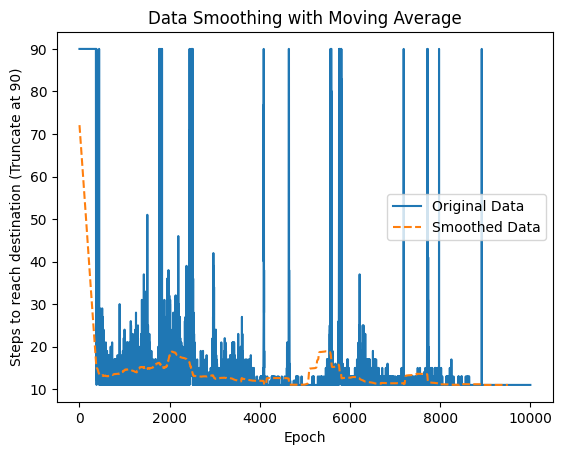

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Original data
data = step_list

# Moving average function
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

# Apply moving average
smoothed_data = moving_average(data, window_size=500)

# Plot original and smoothed data
plt.plot(data, label="Original Data")
plt.plot(range(1, len(smoothed_data) + 1), smoothed_data, label="Smoothed Data", linestyle="--")
plt.xlabel("Epoch")
plt.ylabel(f"Steps to reach destination (Truncate at {max_steps})")
plt.legend()
plt.title("Data Smoothing with Moving Average")
plt.show()

In [19]:
# This is a test run.
# Model guided the player to go from (1,1) to (N-2,N-2).
x, y = 1, 1
steps = 0
max_steps = N * 4
while steps < max_steps: # truncate if stuck
    
    dist = policy_net(sub_maze(x, y))
    action = dist.sample()
    logp = dist.log_prob(action)

    print(f"step: {steps}, {x, y}")
    steps += 1
    if move(action.item()) == 1:
        print(f"step: {steps}, {x, y}")
        break


step: 0, (1, 1)
step: 1, (2, 1)
step: 2, (2, 2)
step: 3, (2, 3)
step: 4, (2, 4)
step: 5, (2, 5)
step: 6, (3, 5)
step: 7, (3, 6)
step: 8, (4, 6)
step: 9, (5, 6)
step: 10, (6, 6)
step: 11, (7, 6)
step: 12, (7, 7)


In [ ]:
# What is the most likely direction to go from each position?
#
# With training, the agent will learn to go
# from top left to bottom right more efficiently.
# It learns to walk around the blockages to go bottom right.
D_sign = ['v', '^', '<', '>']

for i in range(N):
    for j in range(N):
        if maze[i][j] == 0:
            dist = policy_net(sub_maze(i, j))
            best_action = torch.argmax(dist.probs).item()
            print(D_sign[best_action], ' ', end='')
        else:
            print(1, ' ', end='')
    print()


1  1  1  1  1  1  1  1  1  
1  v  v  v  v  1  v  v  1  
1  >  >  >  >  v  v  v  1  
1  v  1  >  1  >  v  v  1  
1  v  v  v  v  v  v  v  1  
1  >  v  v  1  >  v  v  1  
1  >  v  v  v  >  v  v  1  
1  1  >  >  >  1  >  >  1  
1  1  1  1  1  1  1  1  1  
